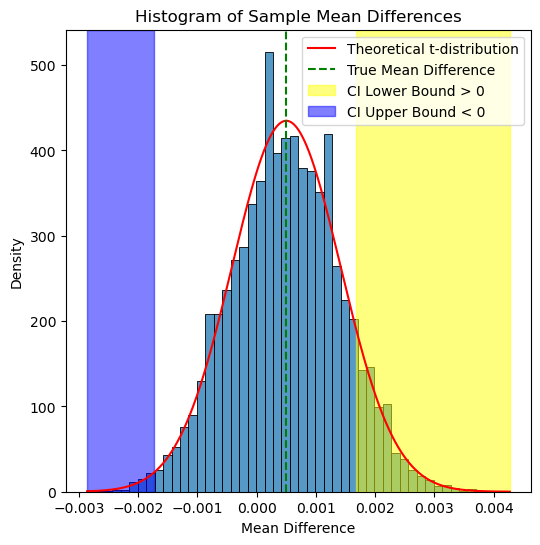

Average of sample mean differences: 0.000494
Minimal Sample Mean Difference for Null Rejection: 0.001682
Maximum Sample Mean Difference for Null Rejection: 0.004273
True mean difference: 0.000500
Proportion of the 'significant' mean differences above zero: 0.078200
Proportion of the 'significant' mean differences below zero: 0.006400


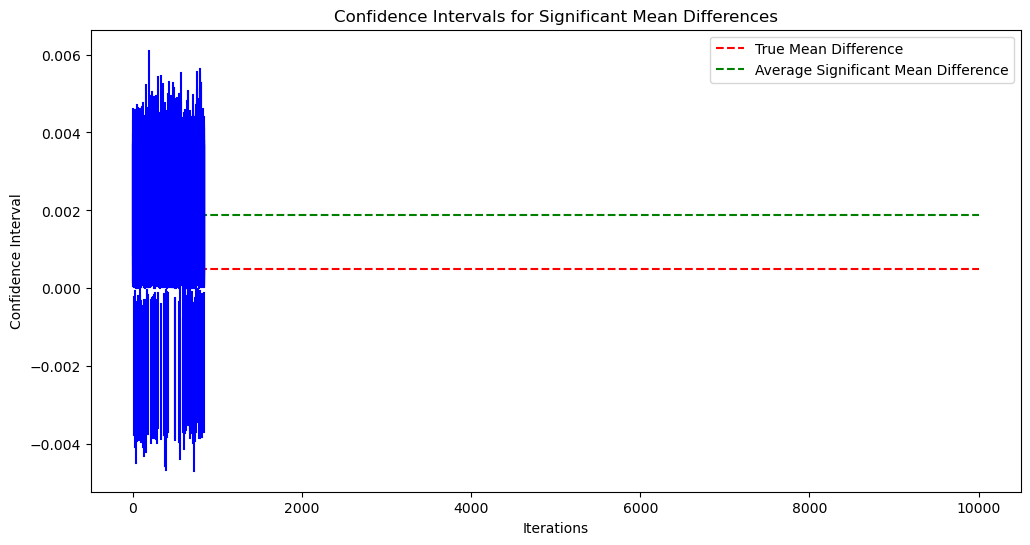

In [1]:
from scipy.stats import t
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt


# Parameters
size = 22000
proportion_a = 0.0091
proportion_b = 0.0096
n_draws = 10000
mean_differences = []
confidence_intervals = []  # Array to store confidence intervals
mean_differences_significant = []
conf_intervals_significant = []

# True mean difference
true_mean_diff = proportion_b - proportion_a

# Draw samples and perform calculations
for _ in range(n_draws):
    sample_a = np.random.binomial(1, proportion_a, size)
    sample_b = np.random.binomial(1, proportion_b, size)
    mean_diff = np.mean(sample_b) - np.mean(sample_a)
    mean_differences.append(mean_diff)


    # Compute standard deviation and standard error for both samples
    std_a = np.std(sample_a, ddof=1)
    std_b = np.std(sample_b, ddof=1)
    se_a = std_a / np.sqrt(size)
    se_b = std_b / np.sqrt(size)

    # Compute standard error for the difference
    std_err = np.sqrt(se_a**2 + se_b**2)
    lb, ub = t.interval(0.95, 2 * size - 2, loc=mean_diff, scale=std_err)
    confidence_intervals.append((lb, ub))


# Identify region where confidence intervals are greater than zero
region_min = min(md for md, (lb, _) in zip(mean_differences, confidence_intervals) if lb > 0)
region_max = max(md for md, (lb, _) in zip(mean_differences, confidence_intervals) if lb > 0)


# Identify mean differences whose confidence intervals either exceed 0 or fall below 0
mean_differences_significant = [md for md, (lb, ub) in zip(mean_differences, confidence_intervals) if lb > 0 or ub < 0]


# Identify confidence intervals that are either above 0 or below 0
conf_intervals_significant = [(lb, ub) for lb, ub in confidence_intervals if lb > 0 or ub < 0]


# Identify region where confidence intervals upper bound are below zero
region_min_below_zero = min((md for md, (_, ub) in zip(mean_differences, confidence_intervals) if ub < 0), default=None)
region_max_below_zero = max((md for md, (_, ub) in zip(mean_differences, confidence_intervals) if ub < 0), default=None)


# Compute standard error for plotting a theoretical distribution
pooled_var = (proportion_a * (1 - proportion_a) / size) + (proportion_b * (1 - proportion_b) / size)
std_err = np.sqrt(pooled_var)


# Compute degrees of freedom
df = 2 * size - 2

# Define theoretical distribution (we use a t-distribution for that, which at our sample sizes is just a normal distribution)
x = np.linspace(min(mean_differences), max(mean_differences), 1000)
y = t.pdf(x, df, loc=true_mean_diff, scale=std_err)


# Identify regions and count proportions
above_zero_count = sum(1 for lb, _ in confidence_intervals if lb > 0)
below_zero_count = sum(1 for _, ub in confidence_intervals if ub < 0)
prop_above_zero = above_zero_count / n_draws
prop_below_zero = below_zero_count / n_draws


# Plotting
plt.figure(figsize=(6, 6))
sns.histplot(mean_differences, kde=False, bins=50, common_norm=False, stat="density") # use density to match PDF
plt.plot(x, y, label='Theoretical t-distribution', color='red') # plot t-distribution
plt.axvline(x=true_mean_diff, color='green', linestyle='--', label='True Mean Difference') # vertical line for true mean difference
plt.axvspan(region_min, region_max, color='yellow', alpha=0.5, label='CI Lower Bound > 0') # highlight region
if region_min_below_zero is not None and region_max_below_zero is not None:
    plt.axvspan(region_min_below_zero, region_max_below_zero, color='blue', alpha=0.5, label='CI Upper Bound < 0') # highlight region below zero
plt.xlabel('Mean Difference')
plt.ylabel('Density')
plt.title('Histogram of Sample Mean Differences')
plt.legend()
plt.show()


# Print results
print(f"Average of sample mean differences: {np.mean(mean_differences):.6f}")
print(f"Minimal Sample Mean Difference for Null Rejection: {region_min:.6f}")
print(f"Maximum Sample Mean Difference for Null Rejection: {region_max:.6f}")
print(f"True mean difference: {true_mean_diff:.6f}")
print(f"Proportion of the 'significant' mean differences above zero: {prop_above_zero:.6f}")
print(f"Proportion of the 'significant' mean differences below zero: {prop_below_zero:.6f}")

## Plotting confidence intervals
plt.figure(figsize=(12, 6))
plt.hlines(y=true_mean_diff, xmin=0, xmax=n_draws, color='red', label='True Mean Difference', linestyles='dashed')
mean_diff_significant = np.mean(mean_differences_significant)
plt.hlines(y=mean_diff_significant, xmin=0, xmax=n_draws, color='green', label='Average Significant Mean Difference', linestyles='dashed')


for i, (lb, ub) in enumerate(conf_intervals_significant):
    plt.plot([i, i], [lb, ub], color='blue')


plt.xlabel('Iterations')
plt.ylabel('Confidence Interval')
plt.title('Confidence Intervals for Significant Mean Differences')
plt.legend()
plt.show()